In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import shape, mapping, Point, MultiPolygon, Polygon, LineString
from shapely.ops import transform, split
from shapely.validation import make_valid
from shapely.wkt import loads

import matplotlib.pyplot as plt

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action = "ignore", category = SettingWithCopyWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/'NEXUS-PARSEC - TCCs'/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus
!ls *.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/NEXUS-PARSEC - TCCs/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus
dataset_all_clusters.csv  dataset.csv	       setores_nexus_2010.csv
dataset_clean.csv	  NEXUS_data_2010.csv


### Projection variables

In [4]:
MERCATOR_CRS = "EPSG:3857"  # Mercator projection CRS.
#METRIC_CRS = "EPSG:32634"   # Metric CRS. Useful for calculations
METRIC_CRS = {"proj":"cea"}
WGS84_CRS = "EPSG:4326"     # World Geodetic System
SIRGAS_CRS = "EPSG:4674"    # SIRGAS 2000, a projection for LATAM

PLOT_CRS = MERCATOR_CRS

In [5]:
DF_PATH = r"NEXUS_data_2010.csv"
df = pd.read_csv(DF_PATH, sep = ",", quotechar = '"', encoding = "iso-8859-1")
df["TYPE"] = df["TIPO"].replace("URBANO", "URBAN") # Translate situation name to english
geo = gpd.GeoDataFrame(df, crs = MERCATOR_CRS, geometry = [loads(mpoly) for mpoly in df["WKT"]])
geo.head()

,Unnamed: 0,year,Cod_setor,TIPO,Cod_municipio,Cod_estado,income,longevity,literacy,WKT,TYPE,geometry
0,0,2010,110030405000001,URBANO,1100304,11,0.800035,0.800000,0.996329,MultiPolygon (((-6694800.91148638 -1429885.364...,URBAN,"MULTIPOLYGON (((-6694800.911 -1429885.364, -66..."
1,1,2010,110030405000002,URBANO,1100304,11,0.727118,0.766667,0.979336,MultiPolygon (((-6694910.44660865 -1430379.588...,URBAN,"MULTIPOLYGON (((-6694910.447 -1430379.589, -66..."
2,2,2010,110030405000003,URBANO,1100304,11,0.732076,0.833333,0.964231,MultiPolygon (((-6695004.30229773 -1429829.110...,URBAN,"MULTIPOLYGON (((-6695004.302 -1429829.110, -66..."
3,3,2010,110030405000004,URBANO,1100304,11,0.787907,0.766667,0.993087,MultiPolygon (((-6694625.03233981 -1429016.066...,URBAN,"MULTIPOLYGON (((-6694625.032 -1429016.066, -66..."
4,4,2010,110030405000005,URBANO,1100304,11,0.642104,0.733333,0.947658,MultiPolygon (((-6695544.27307255 -1428781.091...,URBAN,"MULTIPOLYGON (((-6695544.273 -1428781.091, -66..."


Now we have the NEXUS dataset loaded into the code.\
However, we don't need some columns since they either represent unused or duplicated data:

In [6]:
geo_clean = geo.drop(
    ["Unnamed: 0", "year", "TYPE", "income", "longevity", "literacy", "WKT"], 
    axis='columns'
)
cols = geo_clean.columns.tolist()
cols.sort()
geo_clean = geo_clean[cols]

geo_clean.head()

,Cod_estado,Cod_municipio,Cod_setor,TIPO,geometry
0,11,1100304,110030405000001,URBANO,"MULTIPOLYGON (((-6694800.911 -1429885.364, -66..."
1,11,1100304,110030405000002,URBANO,"MULTIPOLYGON (((-6694910.447 -1430379.589, -66..."
2,11,1100304,110030405000003,URBANO,"MULTIPOLYGON (((-6695004.302 -1429829.110, -66..."
3,11,1100304,110030405000004,URBANO,"MULTIPOLYGON (((-6694625.032 -1429016.066, -66..."
4,11,1100304,110030405000005,URBANO,"MULTIPOLYGON (((-6695544.273 -1428781.091, -66..."


In [7]:
states = geo_clean['Cod_estado'].unique()
municipalities = geo_clean['Cod_municipio'].unique()
tracts = geo_clean['Cod_setor'].unique()

print(f'O dataset conta com {len(states)} estados, {len(municipalities)} municípios e {len(tracts)} setores censitários.')

O dataset conta com 19 estados, 2512 municípios e 114244 setores censitários.


In [11]:
def merge_geometries(df, column, unique_labels, buffer_k=0.05, debug=False):
  print(f'\nMerging geometries for {column}')
  _df = gpd.GeoDataFrame(data=None)
  for label in unique_labels:
    df_label = df[df[column] == label]
    in_shape = df_label.shape
    df_label['geometry'] = df_label['geometry'].buffer(buffer_k)
    df_label = df_label.dissolve()
    out_shape = df_label.shape

    if debug:
      print(f'{label}: {in_shape} -> {out_shape}')

    _df = gpd.GeoDataFrame(pd.concat([_df, df_label], ignore_index = True), crs = df.crs)
  return _df

In [12]:
geo_states = merge_geometries(geo_clean, 'Cod_estado', states, buffer_k=0.75)
geo_mun = merge_geometries(geo_clean, 'Cod_municipio', municipalities, buffer_k=0.05)

geo_states = geo_states.to_crs(WGS84_CRS)
geo_mun = geo_mun.to_crs(WGS84_CRS)


Merging geometries for Cod_estado

Merging geometries for Cod_municipio


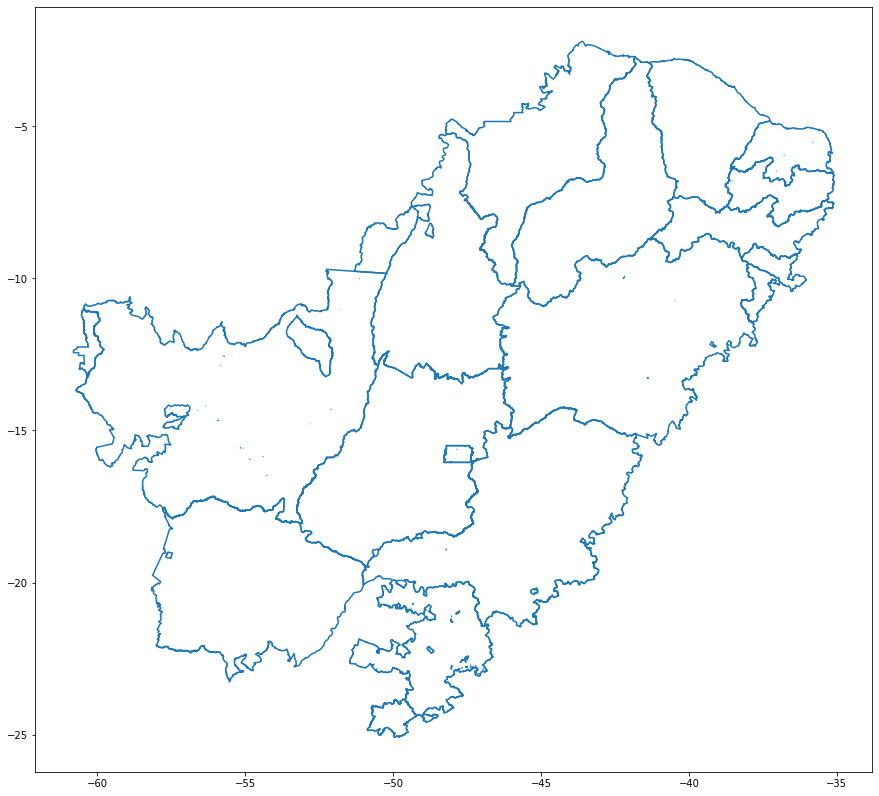

In [13]:
geo_states.boundary.plot(figsize=(15,15))

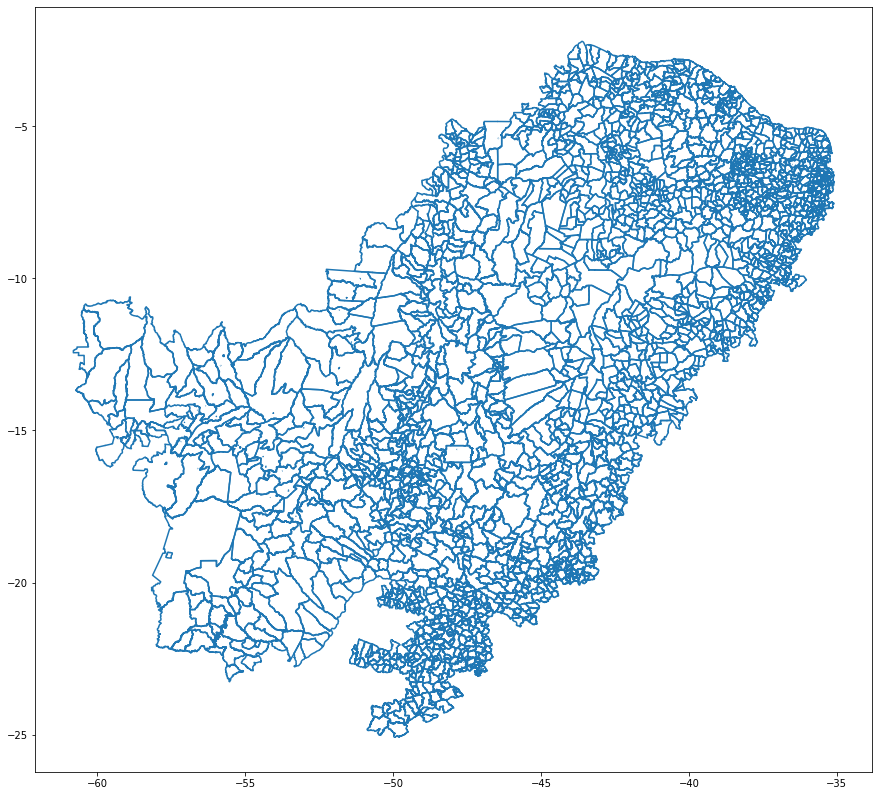

In [14]:
geo_mun.boundary.plot(figsize=(15,15))

In [16]:
geo_states.to_file("estadosBR.json", driver="GeoJSON")
geo_mun.to_file("municipiosBR.json", driver="GeoJSON")

In [ ]:
!ls